# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_RestrictFreeAmt_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
128330,1703818259999,0.000473,1m,2023-12-29 02:50:59.999,0.000517,-0.000045,-0.526804
128331,1703818319999,0.000473,1m,2023-12-29 02:51:59.999,0.000517,-0.000045,-0.521064
128332,1703818379999,0.000473,1m,2023-12-29 02:52:59.999,0.000517,-0.000045,-0.553188
128333,1703818439999,0.000472,1m,2023-12-29 02:53:59.999,0.000517,-0.000045,-0.620815
128334,1703818499999,0.000472,1m,2023-12-29 02:54:59.999,0.000517,-0.000045,-0.648032
128335,1703818559999,0.000472,1m,2023-12-29 02:55:59.999,0.000517,-0.000045,-0.614207
128336,1703818619999,0.000472,1m,2023-12-29 02:56:59.999,0.000517,-0.000045,-0.634453
128337,1703818679999,0.000472,1m,2023-12-29 02:57:59.999,0.000517,-0.000045,-0.636489
128338,1703818739999,0.000472,1m,2023-12-29 02:58:59.999,0.000510,-0.000038,0.353753
128339,1703818799999,0.000472,1m,2023-12-29 02:59:59.999,0.000507,-0.000034,0.793832


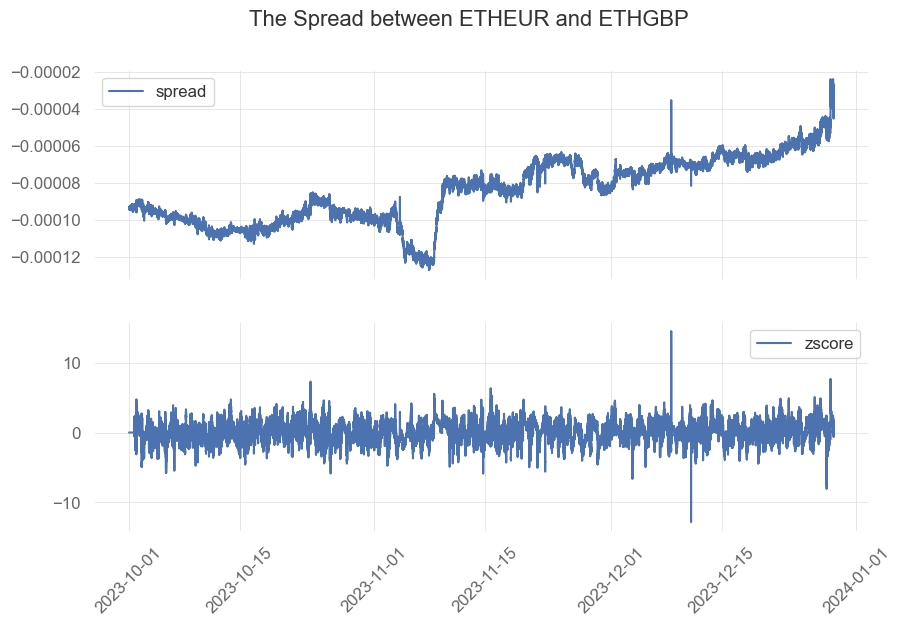

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [12]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 44640


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [13]:
from stable_baselines3.common.env_checker import check_env

env = RL_RestrictFreeAmt_TradeEnv(train)
env.action_space.sample()

array([-0.17397317])

In [14]:
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(50):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    test_env_expt.render()

test_env_expt.close()

  0%|          | 0/50 [00:00<?, ?it/s]

{'position': array([0, 0]), 'zone': 4, 'zscore': array([-2.00894742])}


KeyError: 'holdings'

Tensorboard

## Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

KeyError: 'holdings'

In [ ]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [ ]:
'''
DQN doesn't support Box Actions
'''

# model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
# model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Create the Custom Test Env

In [ ]:
test_env_ppo = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
# test_env_dqn = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [ ]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

## Test Env with Trained Model

In [ ]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

In [ ]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

In [ ]:
# try:
#     os.remove(f"{folder_path}/networth_dqn.csv")
# except OSError:
#     pass

# obs, _ = test_env_dqn.reset()

# for i in trange(max_test_len):
#     action, _states = model_dqn.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_dqn.render()

# test_env_dqn.close()

## Also run randomly generated actions

In [9]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

NameError: name 'test_env_expt' is not defined

### Analyze with Quanstats

In [ ]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

In [ ]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

In [ ]:
best_return

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

In [ ]:
qs.reports.full(best_return['returns'])